# Применение библиотеки Tensor Flow Probability для анализа структурных временных рядов

Для анализа использутеся модуль tfp.sts. Он отличается построением Байесовских моделей структурных временных рядов.

"Байесовский метод" в общем смысле заключается в добавлении шума в модель, для того, чтобы избежать ее переобучения. "Байесовский метод" применяется не только к моделям временных рядов, но и, например, для создания Байесовских нейронных сетей (BNN).

In [1]:
import seaborn as sns
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt

import collections


In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [3]:
months = 2
weeks = 4
days = 7
hours = 24

In [4]:
f_month = months
f_week = weeks * months
f_day = days * weeks * months
f_hour = hours * days * weeks * months

In [5]:
t = pd.date_range(start='1/1/2022', periods=hours*days*weeks*months, freq='H')

# t

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-02-25 14:00:00', '2022-02-25 15:00:00',
               '2022-02-25 16:00:00', '2022-02-25 17:00:00',
               '2022-02-25 18:00:00', '2022-02-25 19:00:00',
               '2022-02-25 20:00:00', '2022-02-25 21:00:00',
               '2022-02-25 22:00:00', '2022-02-25 23:00:00'],
              dtype='datetime64[ns]', length=1344, freq='H')

In [6]:
time = pd.date_range(start='1/1/2022', periods=hours*days*weeks*months, freq='H')
ts = time.size
# ts

1344

In [7]:
hour_of_day_season = np.sin(2*np.pi*np.linspace(0, ts, ts)*f_day)
day_of_week_season = np.sin(2*np.pi*np.linspace(0, ts, ts)*f_week + np.pi/2)
week_of_month_season = np.sin(2*np.pi*np.linspace(0, ts, ts)*f_month) + 3

combined = hour_of_day_season + day_of_week_season + week_of_month_season

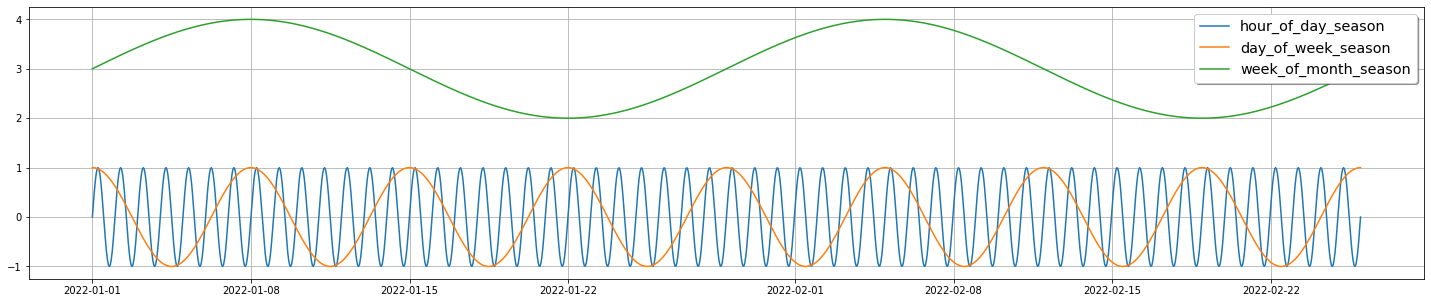

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(t, hour_of_day_season, label='hour_of_day_season')
plt.plot(t, day_of_week_season, label='day_of_week_season')
plt.plot(t, week_of_month_season, label='week_of_month_season')
plt.grid(True, which='both')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.show()

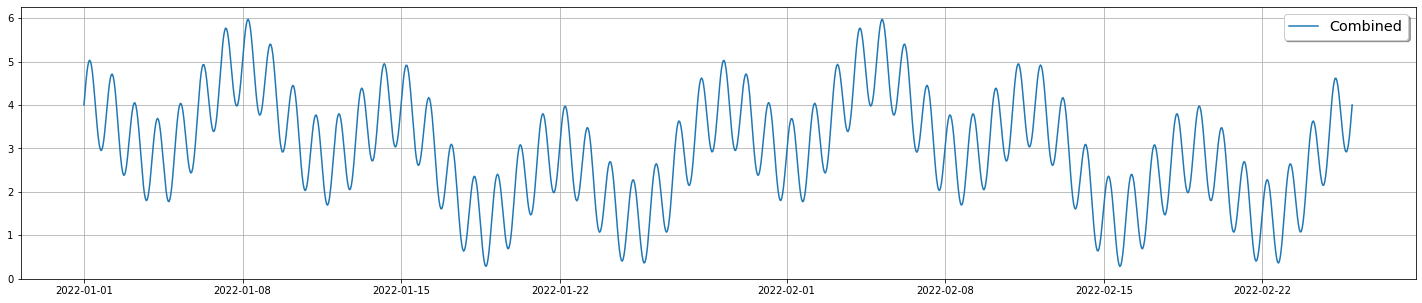

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(t, combined, label='Combined')
plt.grid(True, which='both')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

In [10]:
df = pd.DataFrame(columns=['date', 'value'])
df.date = t
df.value = combined

In [11]:
df_test = df.iloc[-168:]

# df_test

,date,value
1176,2022-02-19 00:00:00,3.226740
1177,2022-02-19 01:00:00,3.469412
1178,2022-02-19 02:00:00,3.678579
1179,2022-02-19 03:00:00,3.839759
1180,2022-02-19 04:00:00,3.941656
...,...,...
1339,2022-02-25 19:00:00,3.084980
1340,2022-02-25 20:00:00,3.258116
1341,2022-02-25 21:00:00,3.478149
1342,2022-02-25 22:00:00,3.730936


In [12]:
df_train = df.iloc[:-168]

# df_train

,date,value
0,2022-01-01 00:00:00,4.000000
1,2022-01-01 01:00:00,4.267664
2,2022-01-01 02:00:00,4.516250
3,2022-01-01 03:00:00,4.729290
4,2022-01-01 04:00:00,4.892648
...,...,...
1171,2022-02-18 19:00:00,2.106550
1172,2022-02-18 20:00:00,2.263315
1173,2022-02-18 21:00:00,2.468617
1174,2022-02-18 22:00:00,2.708675


In [13]:
def build_model(observed_time_series):
  hour_of_day = sts.Seasonal(
      num_seasons = hours, num_steps_per_season=1,
      observed_time_series=observed_time_series,
      name='hour_of_day')
  day_of_week = sts.Seasonal(
      num_seasons=days, num_steps_per_season=hours,
      observed_time_series=observed_time_series,
      name='day_of_week')
  week_of_month = sts.Seasonal(
      num_seasons=weeks, num_steps_per_season=hours*days,
      observed_time_series=observed_time_series,
      name='week_of_month')
  model = sts.Sum([hour_of_day, 
                   day_of_week, 
                   week_of_month], observed_time_series=observed_time_series)
  return model

In [14]:
model = build_model(df_train.value)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

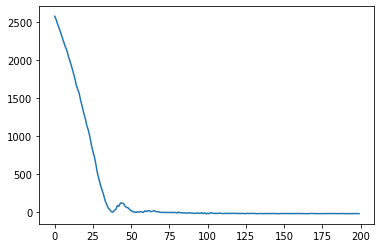

In [15]:
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)

elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_distribution(
            observed_time_series=df_train.value).log_prob,
        surrogate_posterior=variational_posteriors, 
        optimizer=tf.optimizers.Adam(learning_rate=0.1), 
        num_steps=num_variational_steps,
        jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

In [16]:
q_samples = variational_posteriors.sample(50)

In [17]:
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.19591134650471137 +- 0.003844987475115498
hour_of_day/_drift_scale: 0.013972189807682625 +- 0.003949213538845717
day_of_week/_drift_scale: 0.4773272874224753 +- 0.051988817915875334
week_of_month/_drift_scale: 0.029291506390156034 +- 0.05592510734034201


In [18]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(50, 5))
  ax = fig.add_subplot(1, 1, 1)

  plt.grid(True, which='both')

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - 168


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+pd.to_timedelta(num_steps_forecast, unit='h'),
      np.timedelta64(1, "h"),
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [19]:
loc = mdates.HourLocator(interval=24)
fmt = mdates.DateFormatter('%Y-%m-%d')

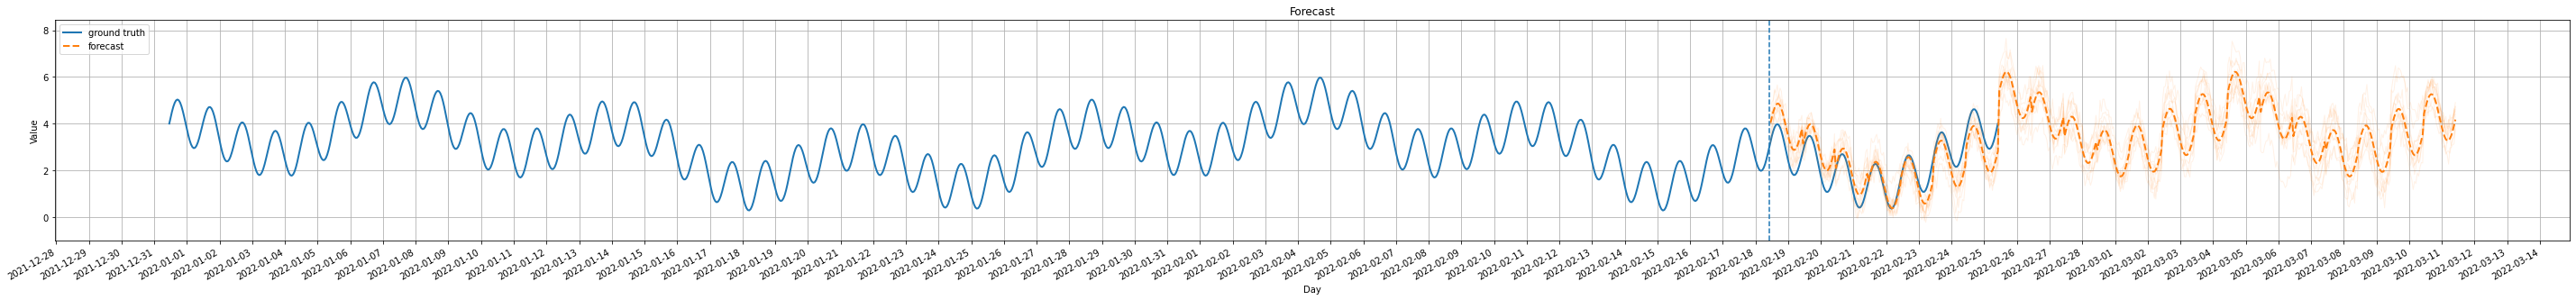

In [20]:
forecast = tfp.sts.forecast(
    model,
    observed_time_series=df_train.value,
    parameter_samples=q_samples,
    num_steps_forecast=504)

num_samples = 10

forecast_mean, forecast_scale, forecast_samples = (
    forecast.mean().numpy()[..., 0],
    forecast.stddev().numpy()[..., 0],
    forecast.sample(num_samples).numpy()[..., 0])

fig, ax = plot_forecast(
    df.date, df.value,
    forecast_mean, forecast_scale, forecast_samples, 
    x_locator=loc, x_formatter=fmt, 
    title="Forecast")
ax.axvline([df_train.iloc[-1:].date], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Value")
ax.set_xlabel("Day")
fig.autofmt_xdate()

In [21]:
# Декомпозиция модели на тренд и сезон
component_dists = sts.decompose_by_component(
    model,
    observed_time_series=df_train.value,
    parameter_samples=q_samples)

In [22]:
component_means_, component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

In [23]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
 
  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(25, 5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax

    plt.grid(True, which='both')
    
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

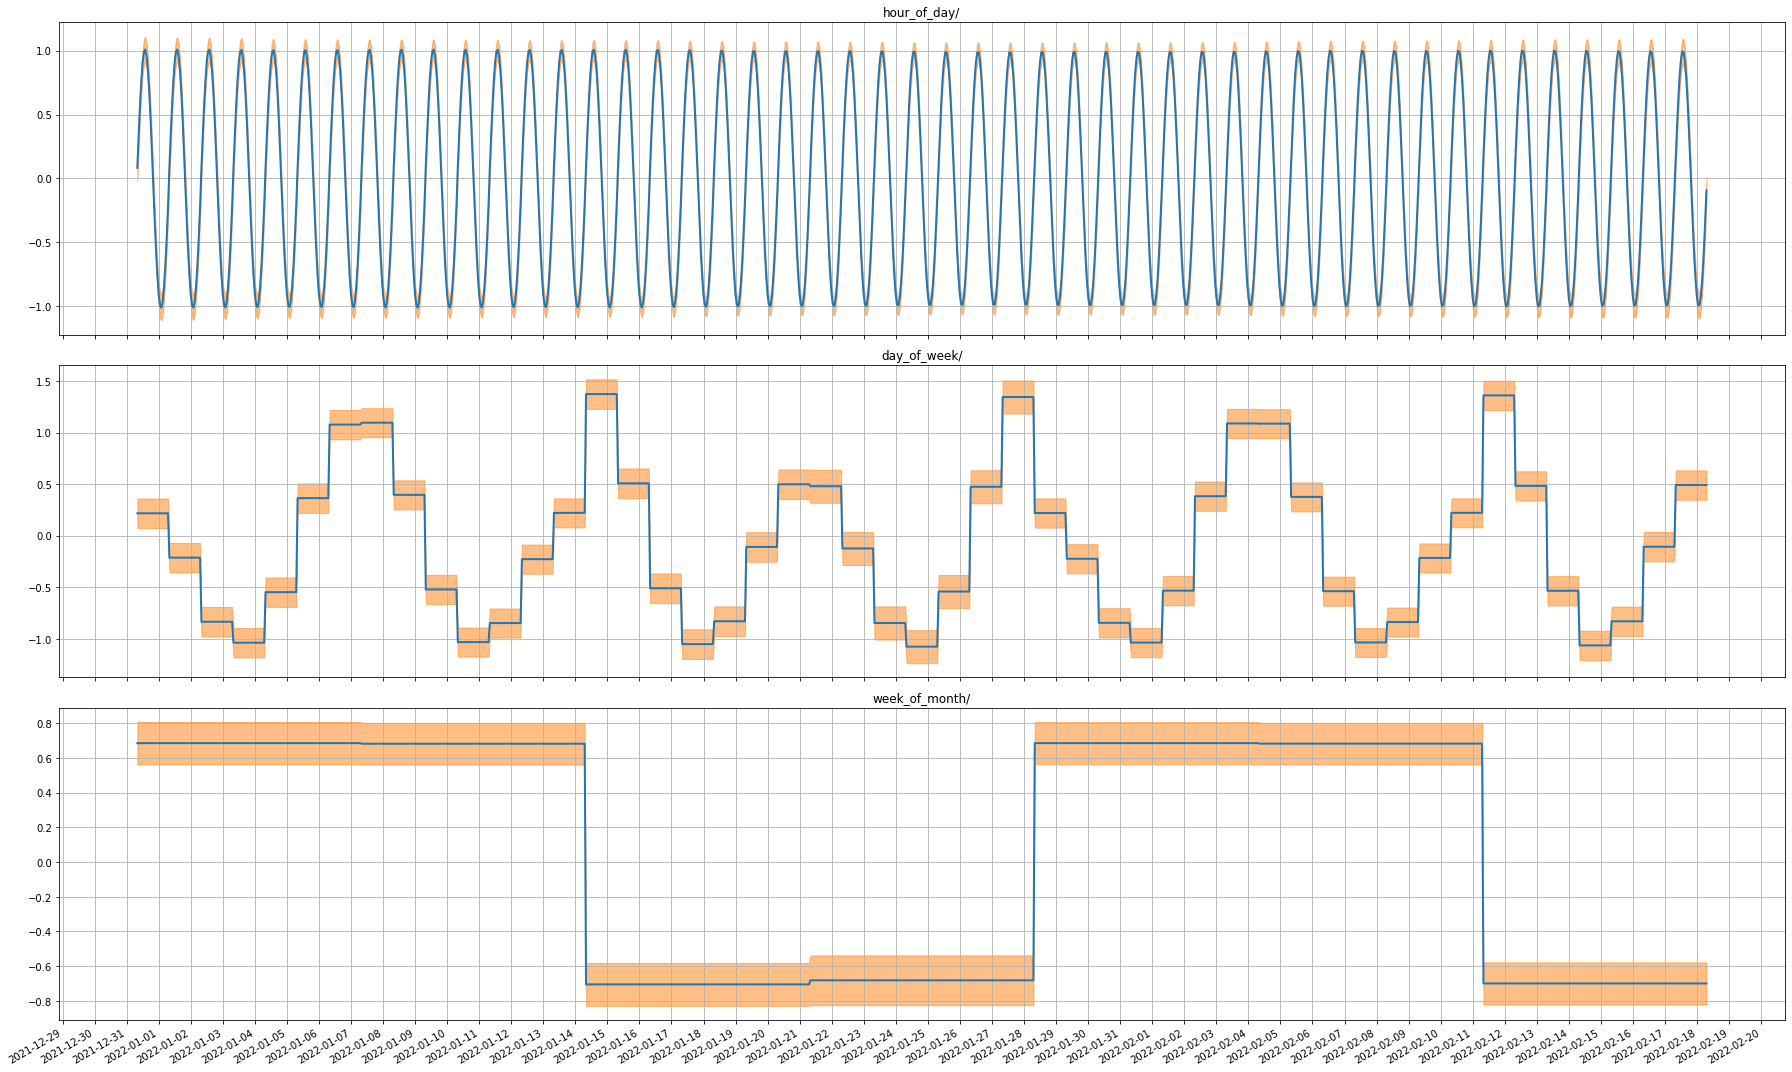

In [24]:
decomposition = plot_components(df_train.date, component_means_, component_stddevs_, x_locator=loc, x_formatter=fmt)